<a href="https://colab.research.google.com/github/pattern-recogniser/wafer-categoriser/blob/main/wafer_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [2]:
def get_df():
  def clean(df):
    # Changes the format of labels from np.array to string
    df['labels'] = df['labels'].apply(lambda x: str(x[0]))
    return df

  # Get the file and set the labels correctly
  with open('/content/drive/MyDrive/Lynceus-takehome/data/waferImg26x26.pkl', 'rb') as f:
      df = pickle.load(f, encoding='latin1')
  df = clean(df)

  # Creating labels for the second model to use
  df['labels_none'] = df['labels'].apply(lambda x: 'none' if x == 'none' else 'not_none')
  return df

In [3]:
def display_label_statistics(df):
  # Calculate the count of each label
  label_counts = df['labels'].value_counts()

  # Calculate the percentage of occurrence of each label
  label_percentages = round((label_counts / len(df)) * 100, 4)

  # Create a new DataFrame to display the results
  label_statistics = pd.DataFrame({
      'Label': label_counts.index,
      'Count': label_counts.values,
      'Percentage': label_percentages.values
  })

  # Sort the DataFrame by count in descending order
  label_statistics = label_statistics.sort_values(by='Count', ascending=False)

  # Display the label statistics
  print(label_statistics)

Examples for label 'Donut':


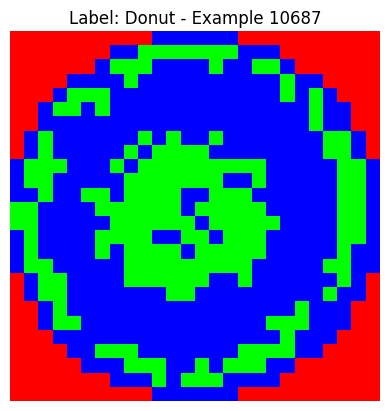

Examples for label 'Random':


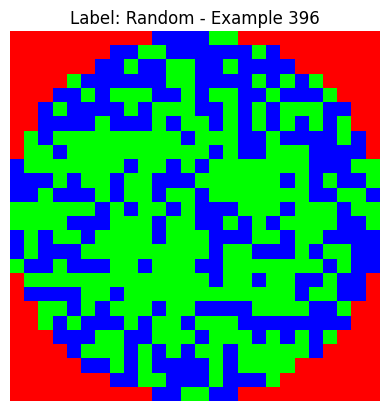

Examples for label 'Center':


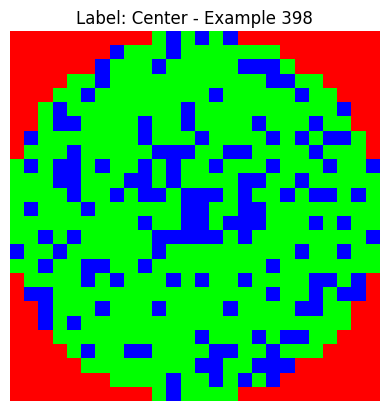

Examples for label 'Edge-Loc':


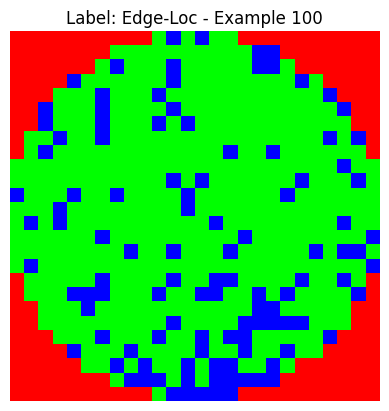

Examples for label 'Edge-Ring':


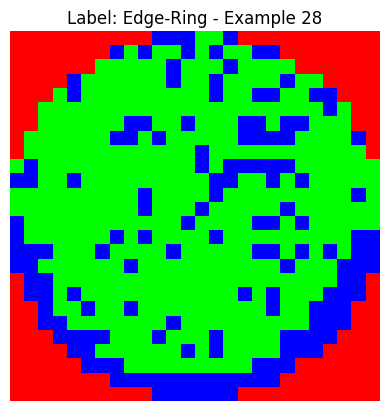

Examples for label 'Loc':


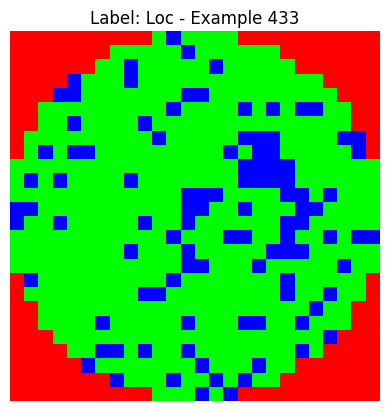

Examples for label 'Near-full':


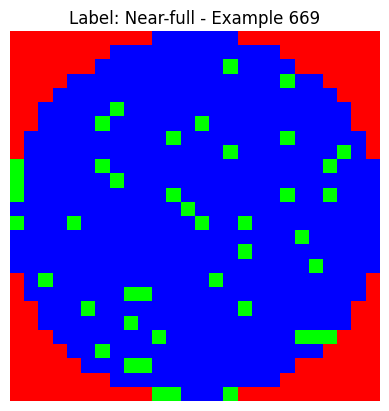

Examples for label 'Scratch':


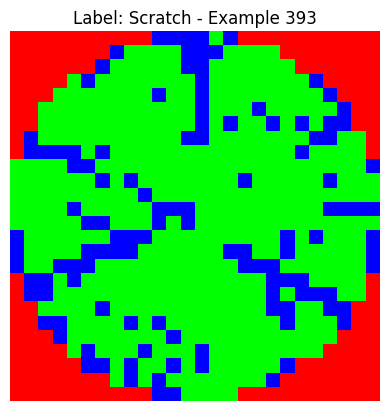

Examples for label 'none':


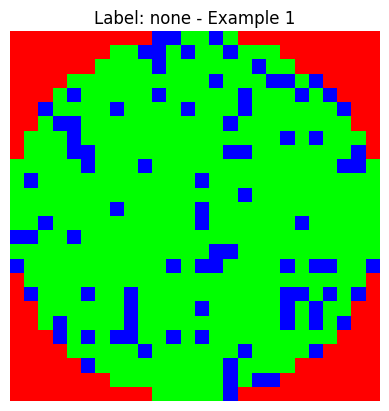

In [83]:
# Function to display a few examples of each label
def display_examples(df, label_column, num_examples=3):
    unique_labels = set(df[label_column])
    for label in unique_labels:
        label_data = df[df[label_column] == label].head(num_examples)
        print(f"Examples for label '{label}':")

        for index, row in label_data.iterrows():
            # Transpose the dimensions to (26, 26, 3) for RGB
            rgb_image = np.transpose(row['images'], (1, 2, 0))

            plt.imshow(rgb_image)
            plt.title(f"Label: {label} - Example {index+1}")
            plt.axis('off')
            plt.show()

# Display examples
display_examples(df, label_column='labels', num_examples=1)

In [5]:
def get_oversampled_data(X, y):
  # Reshape X to a 2D array
  X_reshaped = X.reshape(X.shape[0], -1)

  # Oversample all classes except the majority class and only the trainind dataset
  oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)

  X_over, y_over = oversampler.fit_resample(X_reshaped, y)

  # Reshape X back to its original shape
  X_over = X_over.reshape(X_over.shape[0], X.shape[1], X.shape[2], X.shape[3])

  return X_over, y_over

In [6]:
# Oversampling both train and test splits

# Going to Oversample all majority so that we have only as much as the least frequent class

def get_data_splits(df, y_name='labels', should_oversample=True, should_stratify=True, test_size=0.2, random_state=42):
  # Preprocess the data
  X = np.array([np.transpose(img, (1, 2, 0)) for img in df['images']])
  y = LabelEncoder().fit_transform(df[y_name])

  if should_oversample:
    X, y = get_oversampled_data(X, y)

  # Convert labels to one-hot encoding
  y_one_hot = tf.keras.utils.to_categorical(y)

  # Split the data into training and testing sets
  if should_stratify:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_one_hot, test_size=test_size,
        random_state=random_state, stratify=y_one_hot)
  else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_one_hot, test_size=test_size, random_state=random_state)

  return X_train, X_test, y_train, y_test


def get_model(n_unique_labels, metrics=['accuracy']):
  # Build and train the CNN model using tf.keras
  model = Sequential([
      Conv2D(32, (3, 3), activation='relu', input_shape=(26, 26, 3)),
      MaxPooling2D((2, 2)),
      Conv2D(64, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Conv2D(128, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Flatten(),
      Dense(128, activation='relu'),
      Dense(n_unique_labels, activation='softmax')
  ])

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
  return model

In [7]:
def print_metrics(y_test, y_pred, unique_labels):

  # Convert one-hot encoded labels back to original labels
  y_test_labels = np.argmax(y_test, axis=1)

  # Calculate accuracy
  accuracy = accuracy_score(y_test_labels, y_pred)
  print(f"Overall Accuracy: {accuracy:.4f}\n")


  # Classification Report
  class_report = classification_report(y_test_labels,
                                       y_pred,
                                       target_names=unique_labels)
  print("Classification Report:\n", class_report)

  # Confusion Matrix
  conf_matrix = confusion_matrix(y_test_labels, y_pred)
  conf_matrix_df = pd.DataFrame(conf_matrix, index=unique_labels,
                                columns=unique_labels)
  print("\nConfusion Matrix:\n", conf_matrix_df)

In [58]:
def run_model_old(df, y_name):
  # Train the model
  X_train, X_test, y_train, y_test = get_data_splits(df, y_name)
  model = get_model(np.unique(df[y_name]), metrics=[tf.keras.metrics.Precision()])
  model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2)

  # Get accuracy of model
  y_pred = np.argmax(model.predict(X_test), axis=1)
  print_metrics(y_test, y_pred, np.unique(df[y_name]))
  return model


def get_model_1(X_train, y_train):
  def get_transformed_y_train():
    transformed = []
    # If the one-hot encoding is (0, 0, 0, 0, 0, 0, 0, 0, 1), change it to
    # (1, 0) else to (0, 1)
    # Assuming the last encoding is that for none for model 1
    # and the first encoding is that for none for model 2
    for item in y_train:
      if item[-1] == 1.0:
        transformed.append(np.array([0.0, 1.0]))
      else:
        transformed.append(np.array([1.0, 0.0]))
    return np.array(transformed)

  model = get_model(2, metrics=[tf.keras.metrics.Precision()])
  model.fit(X_train, get_transformed_y_train(), epochs=1, batch_size=32, validation_split=0.2)
  return model

def get_model_2(X_train, y_train):
  model = get_model(9, metrics=[tf.keras.metrics.Precision()])
  model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2)
  return model

# def run_model(X_train, y_train):
#   # Train the model
#   # X_train, X_test, y_train, y_test = get_data_splits_v2(X, y, y_name)
#   model = get_model(np.unique(df[y_name]), metrics=[tf.keras.metrics.Precision()])
#   model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2)

#   # Get accuracy of model
#   y_pred = np.argmax(model.predict(X_test), axis=1)
#   print_metrics(y_test, y_pred, np.unique(df[y_name]))
#   return model

In [59]:
def mega_model(X_test, model_1, model_2):
  y_pred = np.argmax(model_1.predict(X_test), axis=1)
  y_pred_2 = np.argmax(model_2.predict(X_test), axis=1)
  y_pred_2[y_pred == ]
  return y_pred, y_pred_2

SyntaxError: invalid syntax (<ipython-input-59-7e8061f02ef7>, line 4)

In [10]:
def main(df):
  # Get the df
  # df = get_df()

  # split the data to get a well stratified test data
  # This test data will be used for final reporting
  X_train, X_test, y_train, y_test = get_data_splits(df, 'labels')

  # Get the first model
  print("############ MODEL 1\n")
  model_1 = get_model_1(X_train, y_train)

  # Train the second model
  # Seond model will be trained only on those rows where
  # the first_level_label is not_none
  print("############ MODEL 2\n")
  model_2 = get_model_2(X_train, y_train)


  # Call the clubbing function on the test set
  y_pred = mega_model(X_test, model_1, model_2)

  # Report the metrics on the results of the clubbing function - TODO: add viz



  # Train the model

  # Make predictions on the test set

  # labels_array = df['labels']
  # unique_labels = np.unique(labels_array)

  # print(metrics)

In [60]:
df = get_df()

In [ ]:
main(df)

In [61]:
X_train, X_test, y_train, y_test = get_data_splits(df, 'labels')

In [62]:
model_1 = get_model_1(X_train, y_train)

2428/2428 [==============================] - 82s 33ms/step - loss: 0.0717 - precision_6: 0.9729 - val_loss: 0.0145 - val_precision_6: 0.9968


In [33]:
y_pred_1 = np.argmax(model_1.predict(X_test), axis=1)

759/759 [==============================] - 7s 9ms/step


In [22]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [63]:
model_2 = get_model_2(X_train, y_train)

2428/2428 [==============================] - 88s 36ms/step - loss: 0.2687 - precision_7: 0.9514 - val_loss: 0.0202 - val_precision_7: 0.9960


In [64]:
y_pred_2 = np.argmax(model_2.predict(X_test), axis=1)

759/759 [==============================] - 7s 9ms/step


In [65]:
Counter(y_pred_1)

Counter({1: 21661, 0: 2620})

1

In [ ]:
y_pred_2[:10]

In [39]:
Counter(y_pred_2)

Counter({6: 2698,
         1: 2697,
         2: 2166,
         0: 2715,
         4: 2689,
         7: 2712,
         3: 2718,
         8: 3188,
         5: 2698})

In [66]:
list_1 = list(y_pred_1)
list_2 = list(y_pred_2)

In [67]:
final_result = []
for i, item in enumerate(list_1):
  if item == 1:
    # not_none
    final_result.append(list_2[i])
  else:
    final_result.append(8)

In [68]:
final_y_pred = np.array(final_result)

In [69]:
y_test.shape

(24281, 9)

In [70]:
final_y_pred.shape

(24281,)

In [71]:
print_metrics(y_pred=final_y_pred, y_test=y_test, unique_labels=np.unique(df["labels"]))

Overall Accuracy: 0.9969

Classification Report:
               precision    recall  f1-score   support

      Center       1.00      1.00      1.00      2698
       Donut       1.00      1.00      1.00      2697
    Edge-Loc       0.99      0.99      0.99      2698
   Edge-Ring       0.99      1.00      1.00      2698
         Loc       0.99      1.00      0.99      2698
   Near-full       1.00      1.00      1.00      2698
      Random       1.00      1.00      1.00      2698
     Scratch       1.00      1.00      1.00      2698
        none       0.99      0.99      0.99      2698

    accuracy                           1.00     24281
   macro avg       1.00      1.00      1.00     24281
weighted avg       1.00      1.00      1.00     24281


Confusion Matrix:
            Center  Donut  Edge-Loc  Edge-Ring   Loc  Near-full  Random  \
Center       2698      0         0          0     0          0       0   
Donut           0   2697         0          0     0          0       0   
Edg